In [70]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score

from riskyneuroarousal.modeling.behavioral_models import convert_subjective
from riskyneuroarousal.utils.load_data import load_behavioral_data

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# false discovery control
from scipy.stats import false_discovery_control

In [2]:
x = []
for file in os.listdir():
    if file.split("_")[0] == "EV" or file.split("_")[0] == "CPT":
        if file.split("_")[-2] == "subjectFit":
            x.append(pd.read_csv(file))
model_fits = pd.concat(x, ignore_index=True)

In [3]:
data = load_behavioral_data(min_RT = 0.2)
data['history'] = data.groupby('sub')['accept'].shift(1).fillna(0).astype(int)

In [4]:
subs_df = {m : [] for m in model_fits["model"].unique()}
for m in subs_df.keys():
    for sub in data["sub"].unique():
        params = model_fits.query(f"sub == {sub} & model == '{m}'").reset_index().pivot(index = "sub", columns = "param_names", values = "estimates").reset_index()
        df2 = convert_subjective(data.query(f"sub == {sub}").reset_index(), params, model = m)
        subs_df[m].append(df2)
    subs_df[m] = pd.concat(subs_df[m], axis=0)

In [57]:
print("Performance")
res_model_per = {"model": [], "acc" : [], "sub" : []}
for m in subs_df:
    model_sub_df = subs_df[m]
    for s in model_sub_df["sub"].unique():
        model_sub_df_s = model_sub_df.query(f"sub == {s}")
        res_model_per["model"].append(m)
        res_model_per["acc"].append(np.mean(model_sub_df_s["accept"] == model_sub_df_s["accept_pred"]))
        res_model_per["sub"].append(s)

res_model_per = pd.DataFrame(res_model_per)

Performance


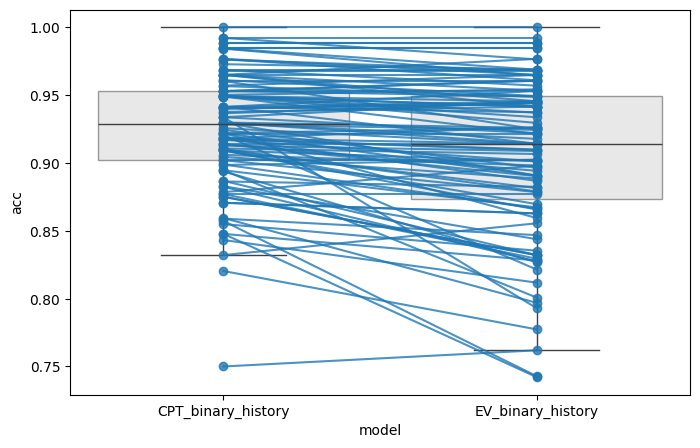

In [64]:
plt.figure(figsize=(8, 5))

# Box plot
sns.boxplot(data=res_model_per.query(f"sub != 56 and model in {['EV_binary_history', 'CPT_binary_history']}"), x='model', y='acc', showcaps=True,
            boxprops={'facecolor':'lightgray', 'alpha':0.5}, showfliers=False)

# Dot and line plot per subject
palette = {'CPT_binary_history': '#1f77b4', 'EV_binary_history': '#ff7f0e'}
for sub, group in res_model_per.query(f"sub != 56 and model in {['EV_binary_history', 'CPT_binary_history']}").groupby('sub'):
    group_sorted = group.sort_values('model')  # ensure correct order
    plt.plot(group_sorted['model'], group_sorted['acc'], marker='o',
             label=sub, alpha=0.8, linewidth=1.5,
             color=palette[group_sorted['model'].iloc[0]])
plt.show()

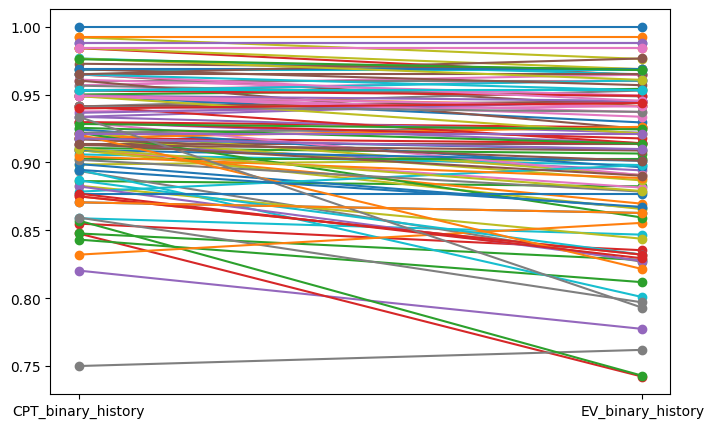

In [61]:
# Pivot the dataframe so each row is a sub and columns are models
pivot_df = res_model_per.query(f"sub != 56 and model in {['EV_binary_history', 'CPT_binary_history']}").pivot(index='sub', columns='model', values='acc')

# Plot
plt.figure(figsize=(8, 5))
for sub in pivot_df.index:
    plt.plot(pivot_df.columns, pivot_df.loc[sub], marker='o', label=sub)

plt.show()

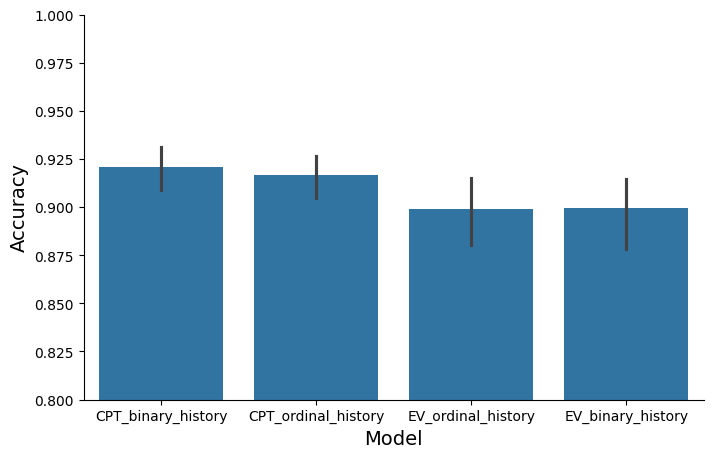

In [69]:
plt.figure(figsize=(8, 5))
sns.barplot(data = res_model_per, x = "model", y = "acc")
plt.ylim(0.8, 1)
sns.despine()
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Change the font type to Helvetica
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [78]:
p_values = []
t_stats = []
names = []
for i in range(4):
    for j in range(4):
        if i > j:
            model1 = res_model_per["model"].unique()[i]
            model2 = res_model_per["model"].unique()[j]
            data1 = res_model_per.query(f"model == '{model1}'")["acc"]
            data2 = res_model_per.query(f"model == '{model2}'")["acc"]
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
            names.append(f"{model1} vs {model2}")

p_values = false_discovery_control(p_values, method = "by")
for i, name in enumerate(names):
    if p_values[i] < 0.05:
        print(f"Significant difference between {name} with p-value: {p_values[i]} and t-stat: {t_stats[i]}")


Significant difference between CPT_ordinal_history vs CPT_binary_history with p-value: 7.190315172153004e-05 and t-stat: -4.542194253511828
Significant difference between EV_ordinal_history vs CPT_binary_history with p-value: 7.190315172153004e-05 and t-stat: -4.630213682183307
Significant difference between EV_ordinal_history vs CPT_ordinal_history with p-value: 0.0008698506798994999 and t-stat: -3.741684669948838
Significant difference between EV_binary_history vs CPT_binary_history with p-value: 7.190315172153004e-05 and t-stat: -4.683136992648054
Significant difference between EV_binary_history vs CPT_ordinal_history with p-value: 0.0008698506798994999 and t-stat: -3.7580561632023493


In [7]:
for model in subs_df:
    model_sub_df = subs_df[model]
    # Create new column for normalized decision value grouped by sub
    model_sub_df["norm_decision_value"] = model_sub_df.groupby("sub")["decision_value"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

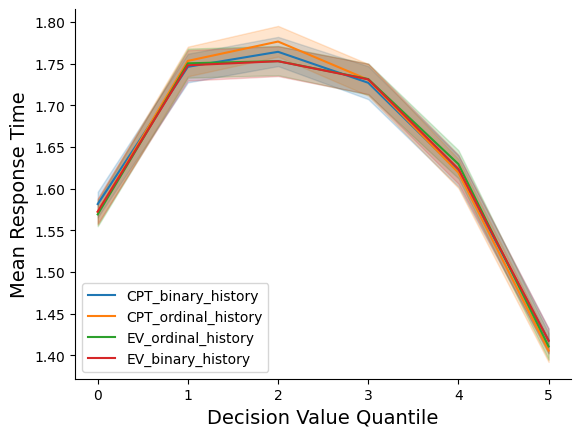

In [87]:
r2_rt = {"model" : [], "r2" : [], "sub" : []}
for m in subs_df:
    model_sub_df = subs_df[m]
    model_sub_df["bin_dv"] = model_sub_df.groupby("sub")["decision_value"].transform(
                                                        lambda x: pd.qcut(x, q=6, labels=False, duplicates='drop')
                                                    )
    sns.lineplot(data = model_sub_df, x = "bin_dv", y = "RT", label = m)

    for sub in model_sub_df["sub"].unique():
        subsub_df = model_sub_df.query(f"sub == {sub}").reset_index()
        
        subsub_df["decision_value_sqred"] = subsub_df["decision_value"] ** 2
        X = subsub_df[['decision_value', 'decision_value_sqred']]  # predictor needs to be 2D
        y = subsub_df['RT']

        model = LinearRegression().fit(X, y)
        r_squared = r2_score(y, model.predict(X))
        r2_rt["r2"].append(r_squared)
        r2_rt["model"].append(m)
        r2_rt["sub"].append(sub)

r2_rt = pd.DataFrame(r2_rt)
sns.despine()
plt.xlabel("Decision Value Quantile", fontsize=14)
plt.ylabel("Mean Response Time", fontsize=14)
plt.show()


In [103]:
p_values = []
t_stats = []
names = []
for i in range(4):
    for j in range(4):
        if i > j:
            model1 = r2_rt["model"].unique()[i]
            model2 = r2_rt["model"].unique()[j]
            data1 = r2_rt.query(f"sub != 56 & model == '{model1}'")["r2"]
            data2 = r2_rt.query(f"sub != 56 & model == '{model2}'")["r2"]
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
            names.append(f"{model1} vs {model2}")
p_values = false_discovery_control(p_values, method = "by")
for i, name in enumerate(names):
    if p_values[i] < 0.05:
        print(f"Significant difference between {name} with p-value: {p_values[i]} and t-stat: {t_stats[i]}")

Significant difference between CPT_ordinal_history vs CPT_binary_history with p-value: 0.006572860215832989 and t-stat: 3.418599054588452
Significant difference between EV_ordinal_history vs CPT_ordinal_history with p-value: 0.012466893345393706 and t-stat: -3.0915823052539824
Significant difference between EV_binary_history vs CPT_ordinal_history with p-value: 0.006572860215832989 and t-stat: -3.595530889887157


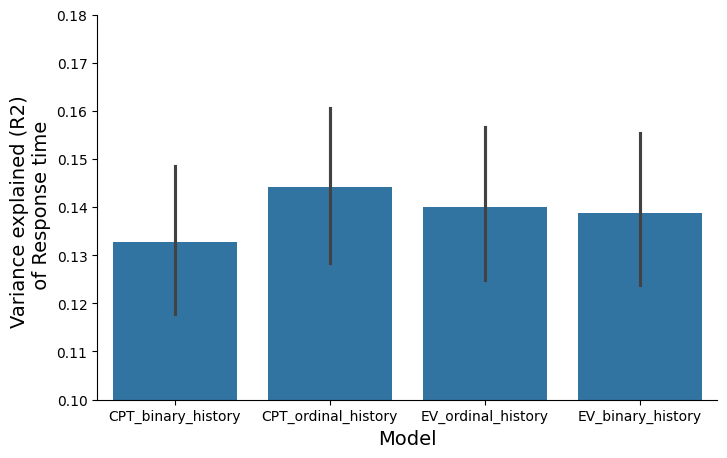

In [94]:
plt.figure(figsize=(8, 5))
sns.barplot(data = r2_rt, x = "model", y = "r2")
sns.despine()
plt.xlabel("Model", fontsize=14)
plt.ylabel("Variance explained (R2) \n of Response time", fontsize=14)
plt.ylim(0.10, 0.18)
# Change the font type to Helvetica
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

<Axes: xlabel='model', ylabel='estimates'>

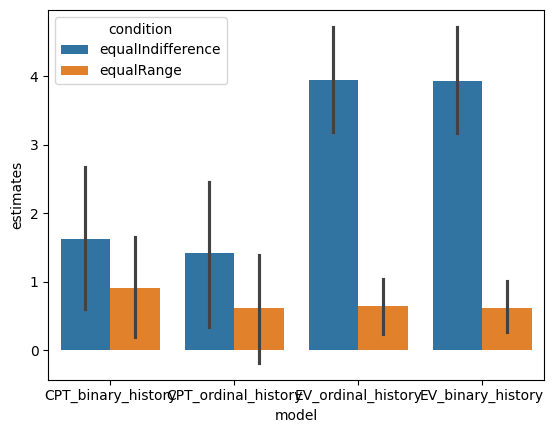

In [105]:
sns.barplot(data=model_fits.query(f"param_names in {['c']}"), x="model", y="estimates", hue="condition")

<Axes: xlabel='model', ylabel='estimates'>

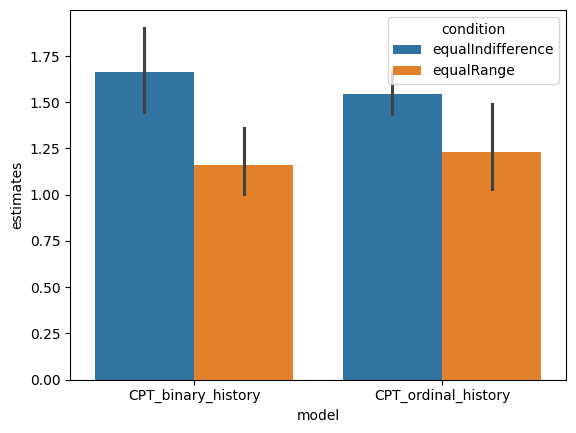

In [106]:
sns.barplot(data=model_fits.query(f"param_names in {['lambd']}"), x="model", y="estimates", hue="condition")

<Axes: xlabel='model', ylabel='estimates'>

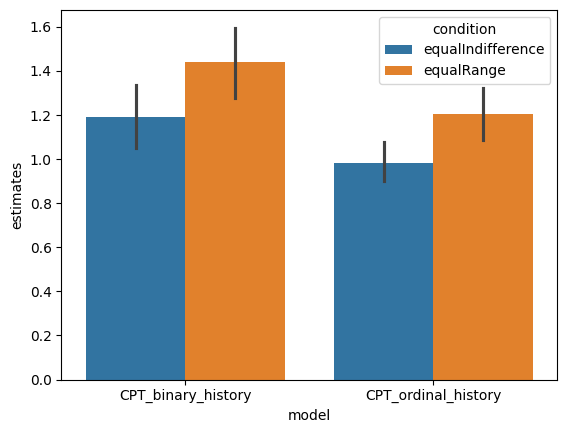

In [107]:
sns.barplot(data=model_fits.query(f"param_names in {['alpha']}"), x="model", y="estimates", hue="condition")

<Axes: xlabel='model', ylabel='estimates'>

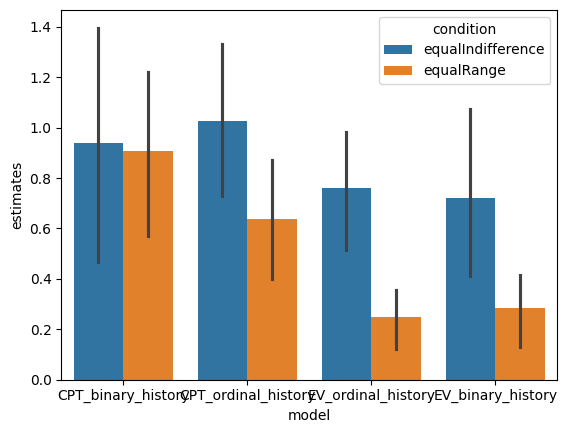

In [108]:
sns.barplot(data=model_fits.query(f"param_names in {['delta']}"), x="model", y="estimates", hue="condition")

In [121]:
for m in subs_df:
    model_sub_df = subs_df[m]
    data[f"SV_{m}"] = model_sub_df["decision_value"].values/10

In [130]:
data.to_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/behavioral_data_SVs.csv", index = False)